# Config

In [3]:
class CONFIG:
    batch_size = 128 # PARAM
    val_ratio = 0.1 # PARAM
    base_layer_name = 'resnet34' # PARAM
    final_layer_n_classes = 37
    num_epochs = 25 # PARAM
    optimizer_lr = 0.001
    scheduler_step_size = 7
    scheduler_gamma = 0.1
    def model_log_name(self):
        return f"LoRA_Pet_{CONFIG.base_layer_name}"

In [3]:
#!pip install torchvision torch
!pip install comet_ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.9/709.9 kB 18.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.8/981.8 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 69.5 MB/s eta 0:00:00:00:01


In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torchvision import models, transforms
from torch.utils.data import DataLoader
import os
from torch.optim import Adam

# Data

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit the model input size
    transforms.ToTensor(),
])

# Load the dataset
train_dataset = OxfordIIITPet(root='data/', split='trainval', download=True, transform=transform)
test_dataset = OxfordIIITPet(root='data/', split='test', download=True, transform=transform)

100%|██████████| 791918971/791918971 [00:03<00:00, 244333115.23it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 106930349.36it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


Size of Training Dataset: 3680
Size of Test Dataset: 3669
Total Labels: 37


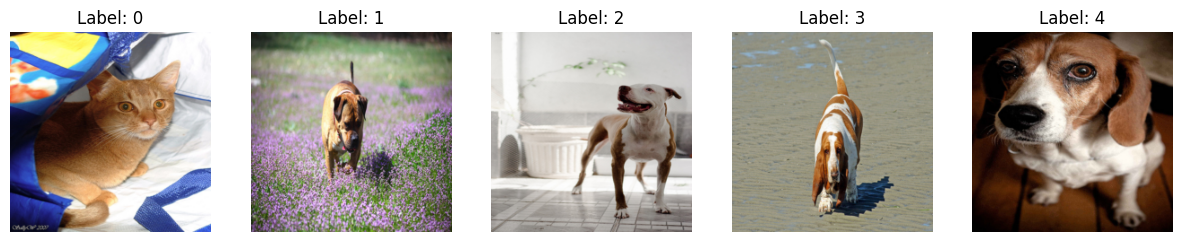

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToPILImage

# Assuming 'train_dataset' and 'test_dataset' are already loaded

# Print the size of train and test datasets
print(f"Size of Training Dataset: {len(train_dataset)}")
print(f"Size of Test Dataset: {len(test_dataset)}")

# Display total labels (assuming label information is available in the dataset)
total_labels = len(np.unique([label for _, label in train_dataset]))
print(f"Total Labels: {total_labels}")

# Function to show sample images for 5 labels
def show_sample_images(dataset, num_labels=5):
    fig, axs = plt.subplots(1, num_labels, figsize=(15, 3))
    label_samples = {}

    for image, label in dataset:
        # Convert tensor image to PIL for display
        image = ToPILImage()(image)

        if label not in label_samples:
            label_samples[label] = image
        if len(label_samples) == num_labels:
            break

    for i, (label, image) in enumerate(label_samples.items()):
        axs[i].imshow(image)
        axs[i].set_title(f"Label: {label}")
        axs[i].axis('off')

    plt.show()

# Show sample images from the training dataset
show_sample_images(train_dataset)


# DataLoader

Batch Size Recommendations:

1.	ResNet-18 or ResNet-34:

* Start with a batch size of 128.
* Increase to 256 if VRAM permits or use mixed precision training for optimization.

2.	ResNet-50 or ResNet-101:

* Start with a batch size of 64.
* Use gradient accumulation to simulate larger batch sizes if needed.


In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split


batch_size = CONFIG.batch_size # PARAM
val_ratio = CONFIG.val_ratio # PARAM


# Define the size of the validation set
val_size = int(val_ratio * len(train_dataset))
train_size = len(train_dataset) - val_size

# Split the dataset
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model

## COMET

In [8]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

In [9]:
import comet_ml
experiment = comet_ml.start(
  api_key=user_secrets.get_secret("comet_api_key"),
  project_name="pet-recognition",
  workspace=user_secrets.get_secret("comet_workspace")
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/bagirov-lab/pet-recognition/b7c4f63f3880480bb082943bbd941b4e

COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET WARNING: Error retrieving Conda package as an explicit file
COMET WARNING: Command '['conda', 'list', '--explicit', '--md5']' returned non-zero exit status 109.
The following arguments were not expected: --md5 --explicit
Run with --help for more information.



## Load Model

In [10]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import get_model, get_model_weights

# Load a pre-trained ResNet model
base_layer_name = CONFIG.base_layer_name # PARAM
model = get_model(name=base_layer_name, weights="DEFAULT")
experiment.log_parameter('base_layer_name', base_layer_name)

num_ftrs = model.fc.in_features

# Adjust the final layer for 37 classes
final_layer_n_classes = CONFIG.final_layer_n_classes
experiment.log_parameter('final_layer_n_classes', final_layer_n_classes)
model.fc = nn.Linear(num_ftrs, final_layer_n_classes)

# LORA adaptation
class LORALayer(nn.Module):
    def __init__(self, adapted_layer, rank=16):
        super(LORALayer, self).__init__()
        self.adapted_layer = adapted_layer
        self.A = nn.Parameter(torch.randn(adapted_layer.weight.size(1), rank))
        self.B = nn.Parameter(torch.randn(rank, adapted_layer.weight.size(0)))

    def forward(self, x):
        low_rank_matrix = self.A @ self.B
        adapted_weight = self.adapted_layer.weight + low_rank_matrix.t()  # Ensure correct shape
        return nn.functional.linear(x, adapted_weight, self.adapted_layer.bias)

# Apply LORA to the last layer of the model
model.fc = LORALayer(model.fc)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


# Train

In [11]:
from torch.optim import lr_scheduler

# PARAM
experiment.log_parameter('num_epochs', CONFIG.num_epochs)


# Check if CUDA (GPU support) is available and use it; otherwise, fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
experiment.log_parameter('device_train', device)

# Move the model to the selected device
model = model.to(device)

# Track losses and accuracies
train_losses = []
val_losses = []
test_losses = []

train_accuracies = []
val_accuracies = []
test_accuracies = []

optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG.optimizer_lr)
experiment.log_parameter('optimizer_lr', CONFIG.optimizer_lr)
experiment.log_parameter('optimizer', "Adam")

criterion = nn.CrossEntropyLoss()
experiment.log_parameter('criterion', "CrossEntropyLoss")


# Implement a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=CONFIG.scheduler_step_size, gamma=CONFIG.scheduler_gamma) # PARAM
experiment.log_parameter('scheduler_step_size', CONFIG.scheduler_step_size)
experiment.log_parameter('scheduler_gamma', CONFIG.scheduler_gamma)

best_val_accuracy = 0.0
best_model_wts = model.state_dict()

for epoch in range(CONFIG.num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()  # Adjust the learning rate based on the scheduler
    train_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_losses.append(val_running_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    # Test phase
    model.eval()
    test_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    test_losses.append(test_running_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_wts = model.state_dict()

    train_loss_epoch = running_loss / len(train_loader)
    val_loss_epoch = val_running_loss / len(val_loader)
    test_running_loss = test_running_loss / len(test_loader)
                                            
    experiment.log_metrics({
        "Train Loss Epoch": train_loss_epoch,
        "Train Accuracy Epoch": train_accuracy,
        "Val Loss Epoch": val_loss_epoch,
        "Val Accuracy Epoch": val_accuracy,
        "Test Loss Epoch": val_loss_epoch,
        "Test Accuracy Epoch": test_accuracy
    }, epoch = epoch)

    print(f'Epoch {epoch}, Train Loss: {train_loss_epoch}, Train Accuracy: {train_accuracy}%, Val Loss: {val_loss_epoch}, Val Accuracy: {val_accuracy}%')

Epoch 0, Train Loss: 68.98586603311392, Train Accuracy: 27.294685990338163%, Val Loss: 321.0549621582031, Val Accuracy: 10.054347826086957%
Epoch 1, Train Loss: 7.581716931783236, Train Accuracy: 44.89734299516908%, Val Loss: 9.207940419514975, Val Accuracy: 30.706521739130434%


# Save

In [12]:
from comet_ml.integration.pytorch import log_model

# Load the best model weights
model.load_state_dict(best_model_wts)

# Log the pytorch model to Comet
log_model(
    experiment=experiment,
    model=model,
    model_name=CONFIG().model_log_name()
)

experiment.register_model(CONFIG().model_log_name())

# Test

Test Accuracy: 32.265625%


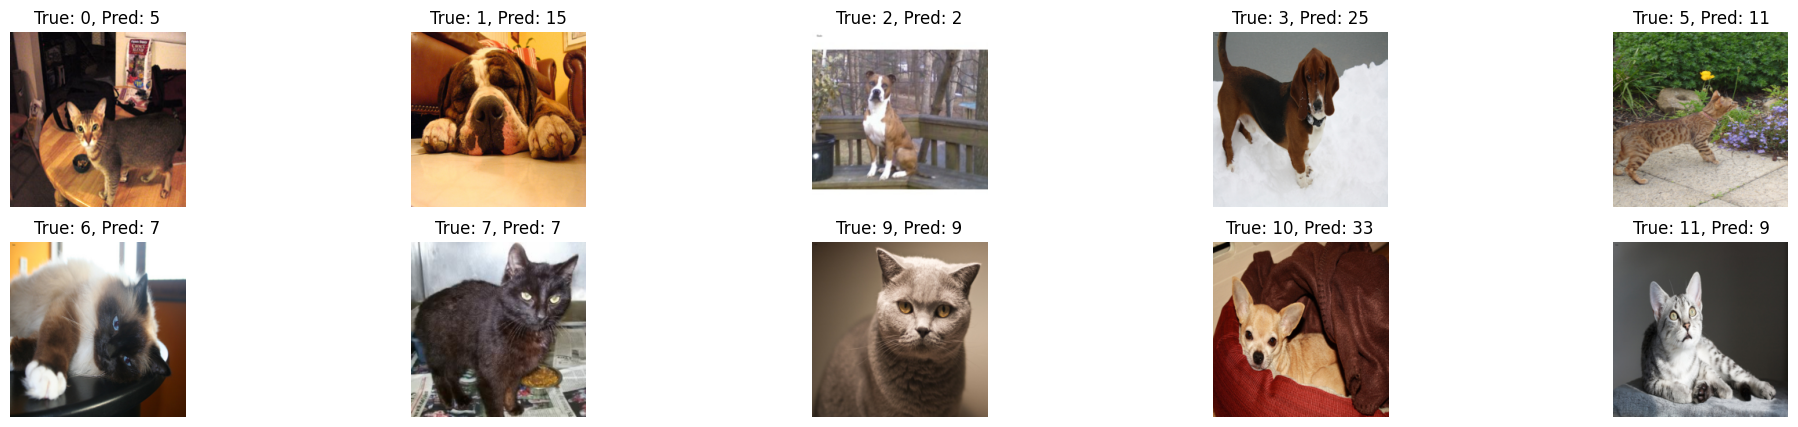

In [15]:
# Test phase (after training is complete and best model is loaded)
model.eval()
correct = 0
total = 0
fig = plt.figure(figsize=(25, 5))  # Define figure size

# We will visualize the first 10 images of the test set
for i, (images, labels) in enumerate(test_loader, start=1):
    if i > 10:  # Stop after visualizing 10 images
        break
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    ax = fig.add_subplot(2, 5, i)  # Plotting 10 images in 2 rows and 5 columns
    ax.imshow(images[0].cpu().numpy().transpose((1, 2, 0)))
    ax.set_title(f"True: {labels[0].item()}, Pred: {predicted[0].item()}")
    ax.axis('off')

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy}%')
plt.show()


In [40]:
from tqdm import tqdm
# import tensorflow as tf

labels_all = None
predicted_all = None
for i, (images, labels) in tqdm(enumerate(test_loader, start=1)):
    images, labels = images.to(device), labels.to(device)
    
    if labels_all is None:
        labels_all = labels
    else:
        labels_all = torch.cat((labels_all, labels))

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    if predicted_all is None:
        predicted_all = predicted
    else:
        predicted_all = torch.cat((predicted_all, predicted))
    
    
total = labels_all.size(0)
correct = (predicted_all == labels_all).sum().item()
test_accuracy = 100 * correct / total

experiment.log_metric("Test Accuracy", test_accuracy, step=None)
experiment.log_confusion_matrix(labels_all, predicted_all)

5it [00:37,  7.40s/it]


{'web': 'https://www.comet.com/api/asset/download?assetId=b6227c264b454e96b7850bd333ef48fe&experimentKey=b7c4f63f3880480bb082943bbd941b4e',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=b6227c264b454e96b7850bd333ef48fe&experimentKey=b7c4f63f3880480bb082943bbd941b4e',
 'assetId': 'b6227c264b454e96b7850bd333ef48fe'}

# End Experiment

In [51]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : parental_catshark_5745
COMET INFO:     url                   : https://www.comet.com/bagirov-lab/pet-recognition/b7c4f63f3880480bb082943bbd941b4e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Test Accuracy [4]        : (17.578125, 32.265625)
COMET INFO:     Train Accuracy Epoch [2] : (27.294685990338163, 44.89734299516908)
COMET INFO:     Train Loss Epoch [2]     : (7.581716931783236, 68.98586603311392)
COMET INFO:     Val Accuracy Epoch [2]   : (10.054347826086957, 30.706521739130434)
COMET INFO:     Val Loss Epoch [2]       : (9.207940419514975, 321.0549621582031)
COMET INFO:   Parameters:
COMET INFO:     base_layer_name       : resnet1